# Behavioral-epidemic models for COVID-19 

This notebook shows how to run the behavioral-epidemic models for COVID-19.

First, we import the necessary libraries:

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from models.mobility_model_age import SEIR_mobility, compute_contact_reductions
from models.compartment_model_age_deaths import SEIR_compartment
from models.function_model_age_deaths import SEIR_function

from models.constants import *

Then, we import the data for Madrid that we will use to run the models:

In [4]:
basin = 'madrid'

epi_data = pd.read_csv(f'./data/{basin}/epi-data/epi_data.csv')
pop_data = pd.read_csv(f'./data/{basin}/population-data/pop_data_Nk.csv')
mob_data = pd.read_csv(f'./data/{basin}/google-mobility-report/google_mobility_data.csv')
hemisphere = pd.read_csv(f"./data/{basin}/hemisphere/hemisphere.csv").hemisphere_code[0]
C = np.load(f"./data/{basin}/contact_matrix/contact_matrix.npz")["arr_0"] 
Nk = pd.read_csv(f"./data/{basin}/population-data/pop_data_Nk.csv").values[0]

## Data-Driven Behavioral (DDB) Model

In the following, we run the Data-Driven Behavioral (DDB) Model. In the DDB model, the force of infection is modulated by a contact reduction factor that is computed as a function of the mobility data. 

First, we compute the contact reduction factor as a function of the mobility data:

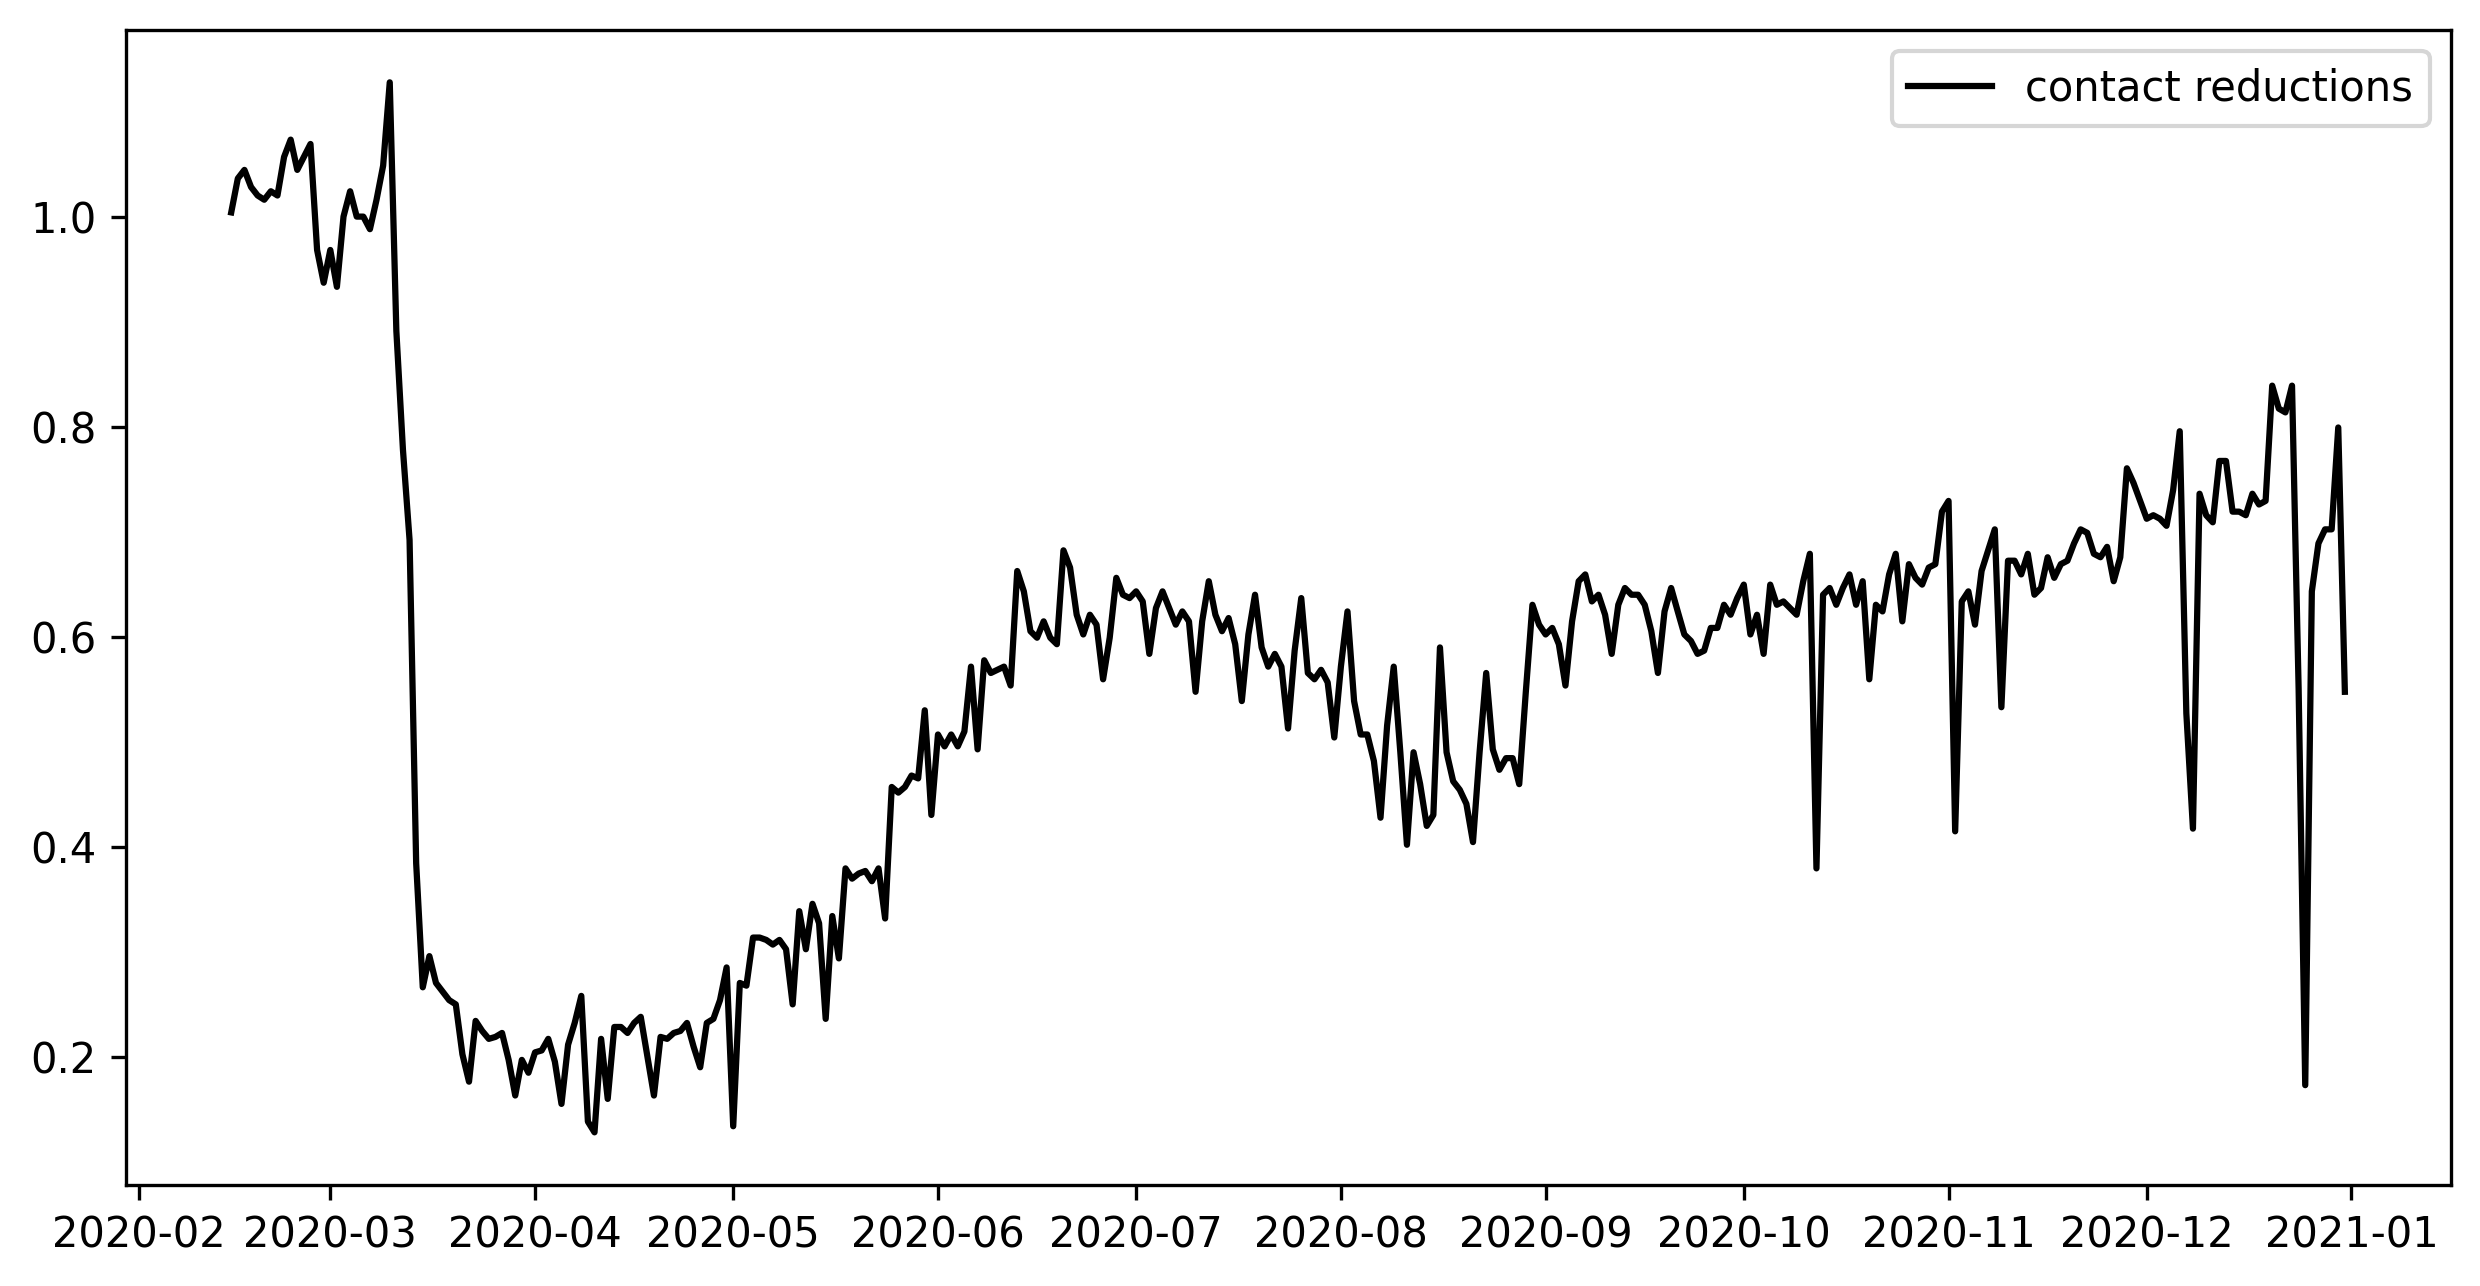

In [5]:
# compute contact reductions 
contact_reductions = compute_contact_reductions(mob_data=mob_data, 
                                                columns=['retail_and_recreation_percent_change_from_baseline',
                                                        'grocery_and_pharmacy_percent_change_from_baseline',
                                                        'transit_stations_percent_change_from_baseline',
                                                        'workplaces_percent_change_from_baseline',
                                                        'residential_percent_change_from_baseline'])

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
contact_reductions["date"] = pd.to_datetime(contact_reductions["date"])
plt.plot(contact_reductions.date, contact_reductions.r.values, label="contact reductions", color='k')
plt.legend()
plt.show()

Next, we run the DDB model:

In [6]:
results = SEIR_mobility(inf_t0=1000, 
                  rec_t0=0,
                  Nk=Nk, 
                  r=contact_reductions.r.values,
                  T=len(mob_data), 
                  R0=2.5, 
                  eps=eps, 
                  mu=mu,
                  ifr=IFR_10age,
                  Delta=14, 
                  C=C, 
                  detection_rate=0.7, 
                  dates=pd.to_datetime(mob_data.date.values), 
                  hemisphere=hemisphere, 
                  seasonality_min=0.75)

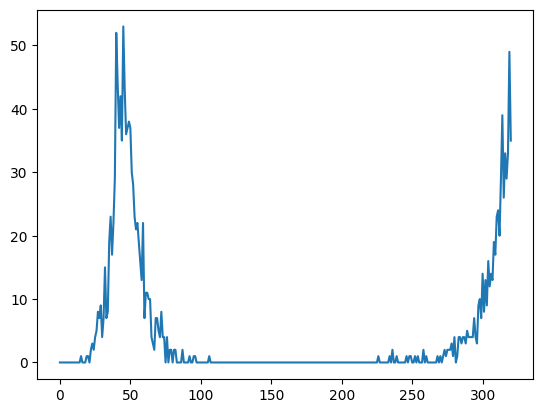

In [7]:
plt.plot(results["deaths"])

## Compartmental Behavioral Feedback (CBF) Model

In the following, we run the Compartmental Behavioral Feedback (CBF) Model. In the CBF model, a new compartment ($S^B$) of individuals that adopt behavioral prevented measures is introduced. As a result of those measures, these individuals get infected at a lower rate, according to a parameter $r<1$.

### multiple gammas and behavioral mechanisms

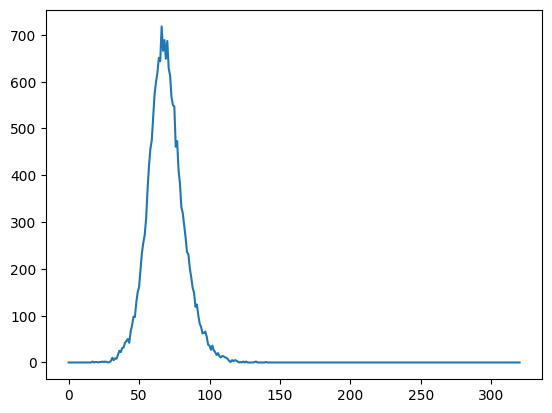

In [15]:
results = SEIR_compartment(inf_t0=1000, 
                     rec_t0=0,
                     Nk=Nk, 
                     T=len(mob_data), 
                     R0=2.5, 
                     eps=eps, 
                     mu=mu, 
                     beta_B=0.5, 
                     mu_B=0.01, 
                     r=0.5, 
                     ifr=IFR_10age,
                     Delta=14, 
                     Delta_std=1,
                     C=C, 
                     detection_rate=0.7,
                     dates=pd.to_datetime(mob_data.date.values), 
                     hemisphere=hemisphere, 
                     seasonality_min=0.75,
                     gamma=-3, 
                     behavioral_mechanism="global")

plt.plot(results["deaths"])

## Effective Force of Infection Behavioral Feedback (EFB) Model